In [22]:
from mtcnn import MTCNN
from skywatchai import FaceNet
import cv2
import numpy as np
import math

import matplotlib.pyplot as plt

In [2]:
def face_detection(filename, detector):
    # img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    img = cv2.imread(filename)
    small_to_large_image_size_ratio = 0.8
    img = cv2.resize(img, (0,0), fx= small_to_large_image_size_ratio, fy= small_to_large_image_size_ratio,
    interpolation=cv2.INTER_CUBIC)
    detections = detector.detect_faces(img)
    print(f'Detected {len(detections)} in this image')
    for face in detections:
        if face['confidence'] > 0.1:
            bbox = face['box']
            keypoints = face['keypoints']
            cv2.rectangle(img,
              (bbox[0], bbox[1]),
              (bbox[0]+bbox[2], bbox[1] + bbox[3]),
              (0,155,255),
              2)
            cv2.circle(img,(keypoints['left_eye']), 2, (0,155,255), 2)
            cv2.circle(img,(keypoints['right_eye']), 2, (0,155,255), 2)
            cv2.circle(img,(keypoints['nose']), 2, (0,155,255), 2)
            cv2.circle(img,(keypoints['mouth_left']), 2, (0,155,255), 2)
            cv2.circle(img,(keypoints['mouth_right']), 2, (0,155,255), 2)
    cv2.imwrite("result_drawn.jpg", img)

In [3]:
detector = MTCNN()
%timeit face_detection('../../test/boys.jpg', detector)

Detected 14 in this image
Detected 14 in this image
Detected 14 in this image
Detected 14 in this image
Detected 14 in this image
Detected 14 in this image
Detected 14 in this image
Detected 14 in this image
17.6 s ± 734 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In [24]:
from PIL import Image
def alignment_procedure(img, left_eye, right_eye):
		
	#this function aligns given face in img based on left and right eye coordinates
	
	left_eye_x, left_eye_y = left_eye
	right_eye_x, right_eye_y = right_eye
	
	#-----------------------
	#find rotation direction
		
	if left_eye_y > right_eye_y:
		point_3rd = (right_eye_x, left_eye_y)
		direction = -1 #rotate same direction to clock
	else:
		point_3rd = (left_eye_x, right_eye_y)
		direction = 1 #rotate inverse direction of clock
	
	#-----------------------
	#find length of triangle edges
	
	a = findEuclideanDistance(np.array(left_eye), np.array(point_3rd))
	b = findEuclideanDistance(np.array(right_eye), np.array(point_3rd))
	c = findEuclideanDistance(np.array(right_eye), np.array(left_eye))
	
	#-----------------------
	
	#apply cosine rule
			
	if b != 0 and c != 0: #this multiplication causes division by zero in cos_a calculation
		
		cos_a = (b*b + c*c - a*a)/(2*b*c)
		angle = np.arccos(cos_a) #angle in radian
		angle = (angle * 180) / math.pi #radian to degree
		
		#-----------------------
		#rotate base image
		
		if direction == -1:
			angle = 90 - angle
		
		img = Image.fromarray(img)
		img = np.array(img.rotate(direction * angle))
	
	#-----------------------
	
	return img #return img anyway

In [27]:
def get_face(img):
    detector = MTCNN()
    detections = detector.detect_faces(img)

    if len(detections) > 0:
        detection = detections[0]
        keypoints = detection["keypoints"]
        left_eye = keypoints["left_eye"]
        right_eye = keypoints["right_eye"]
        
        img = alignment_procedure(img, left_eye, right_eye)
        detections = detector.detect_faces(img)
        x, y, w, h = detection['box']
        cropped_face = img[int(y): int(y+h), int(x) : int(x+w)]
        return cropped_face
    else:
        raise ValueError('Face could not be detected please check the image.')
    return img

In [1]:
from skywatchai import FaceNet

model = FaceNet.loadModel()

In [2]:
input_shape = model.layers[0].input_shape
try:
    image_size = input_shape[0][1:3]
except:
    image_size = input_shape[1:3]

In [15]:
import cv2
import numpy as np
from skywatchai.SkywatchAI import crop_face, get_processed_face
from skywatchai.utils import read_img, getEuclideanDistance, l2_normalization
img1_path = '../../test/i.jpg'
img2_path = '../../test/also-me.jpg'
img1 = read_img(img1_path)
img2 = read_img(img2_path)
face_img1 = get_processed_face(img1, image_size)
face_img2 = get_processed_face(img2, image_size)

In [16]:
emb1 = l2_normalization(model.predict(face_img1)[0, :])
emb2 = l2_normalization(model.predict(face_img2)[0, :])
dist = getEuclideanDistance(emb1, emb2)


verified... they are same person


verified... they are same person


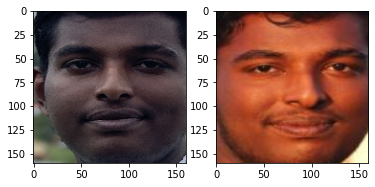

In [19]:
import matplotlib.pyplot as plt
ax = plt.subplot(1, 2, 1)
ax.imshow(face_img1[0])

ax1 = plt.subplot(1, 2, 2)
ax1.imshow(face_img2[0])

threshold = 0.80
if dist < threshold:
    print("verified... they are same person")
else:
    print("unverified! they are not same person!")